In [ ]:
!pip install --quiet cornac==1.15.4

In [ ]:
import os
import sys
import textwrap
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import cornac
from cornac.utils import cache
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.models import UserKNN, ItemKNN
SEED = 42
VERBOSE = False

In [ ]:
sample_df = pd.read_csv(
    cache("https://static.preferred.ai/tutorials/recommender-systems/sample_data.csv"),
    sep=",", names=["UserID", "ItemID", "Rating"]
)
sample_df.head()

,UserID,ItemID,Rating
0,1,1,7
1,1,2,6
2,1,3,7
3,1,4,4
4,1,5,5


The sample dataset in matrix form

In [ ]:
dataset  = cornac.data.Dataset.from_uir(sample_df.itertuples(index=False))
df = pd.DataFrame(dataset.matrix.A,
                  index = [f"User {u+1}" for u in np.arange(dataset.num_users)],
                  columns = [f"Item {i+1}" for i in np.arange(dataset.num_items)])
df.replace(0, np.nan, inplace=True)
df["Mean Rating"] = df.mean(axis=1)
df

,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6,Mean Rating
User 1,7.0,6.0,7.0,4.0,5.0,4.0,5.5
User 2,6.0,7.0,NaN,4.0,3.0,4.0,4.8
User 3,NaN,3.0,3.0,1.0,1.0,NaN,2.0
User 4,1.0,2.0,2.0,3.0,3.0,4.0,2.5
User 5,1.0,NaN,1.0,2.0,3.0,3.0,2.0


The matrix after nomalizing

In [ ]:
ratings = df[df.columns.difference(["Mean Rating"])].values
means = df["Mean Rating"].values[:, np.newaxis]
df[df.columns.difference(["Mean Rating"])] = (ratings - means)
df.drop(columns="Mean Rating")

,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6
User 1,1.5,0.5,1.5,-1.5,-0.5,-1.5
User 2,1.2,2.2,NaN,-0.8,-1.8,-0.8
User 3,NaN,1.0,1.0,-1.0,-1.0,NaN
User 4,-1.5,-0.5,-0.5,0.5,0.5,1.5
User 5,-1.0,NaN,-1.0,0.0,1.0,1.0


##User-Based Methods

For each user, mean rating is: 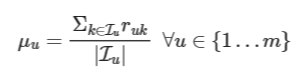  
- Cosine similarity and Pearson correlation coefficent: 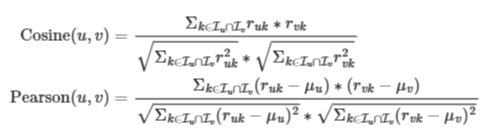  
- Example: Similarity between user 1 and user 3
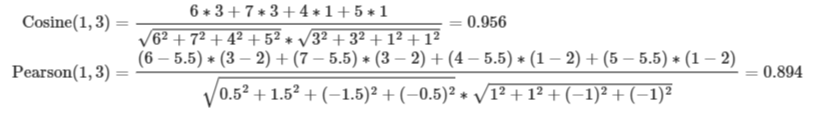

In [ ]:
uknn_cosine = UserKNN(k=2, similarity="cosine", verbose=VERBOSE).fit(dataset)
print(f"Cosine(1, 3) = {uknn_cosine.sim_mat[0, 2]:.3f}")

uknn_pearson = UserKNN(k=2, similarity="pearson", verbose=VERBOSE).fit(dataset)
print(f"Pearson(1, 3) = {uknn_pearson.sim_mat[0, 2]:.3f}")

Cosine(1, 3) = 0.956
Pearson(1, 3) = 0.894


The prediction based on the weighted average of the mean-centered rating. Example: Predicted rating given by User 3 to Item 1 and Item 6.  
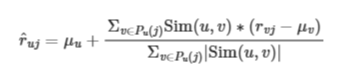  


In [ ]:
print(f"R(3, 1) = {uknn_pearson.score(user_idx=2, item_idx=0):.2f}")
print(f"R(3, 6) = {uknn_pearson.score(user_idx=2, item_idx=5):.2f}")

R(3, 1) = 3.35
R(3, 6) = 0.86


###Employ these algorithms on MovieLens dataset.

We can base the similarity computation based on either the original ratings or the mean-ratings.

In [ ]:
#UserKNN methods
K = 50 #numbr os nearest neighbors
uknn_cosine = UserKNN(k=K, similarity="cosine", name="UserKNN-Cosine", verbose=VERBOSE)
uknn_cosine_mc = UserKNN(k=K, similarity="cosine", mean_centered=True, name="UserKNN-Cosine-MC", verbose=VERBOSE)
uknn_pearson = UserKNN(k=K, similarity="pearson", name="UserKNN-Pearson", verbose=VERBOSE)
uknn_pearson_mc = UserKNN(k=K, similarity="pearson", mean_centered=True, name="UserKNN-Pearson-MC", verbose=VERBOSE)

feedback = movielens.load_feedback(variant="100K")
ratio_split = RatioSplit(feedback, test_size=0.1, seed=SEED, verbose=VERBOSE)
cornac.Experiment(
    eval_method=ratio_split,
    models=[uknn_cosine, uknn_cosine_mc, uknn_pearson, uknn_pearson_mc],
    metrics=[cornac.metrics.RMSE()],
).run()


TEST:
...
                   |   RMSE | Train (s) | Test (s)
------------------ + ------ + --------- + --------
UserKNN-Cosine     | 0.9102 |    0.1436 |   1.9318
UserKNN-Cosine-MC  | 0.8947 |    0.1144 |   1.7262
UserKNN-Pearson    | 0.8947 |    0.1164 |   1.5785
UserKNN-Pearson-MC | 0.8947 |    0.1242 |   2.1185



###Item-Based Methods

We can apply the above similarity function for item-based mothods as well. If Cosine similarity based on the mean-centered rating matrix, there is a variant AdjustedCosine.   
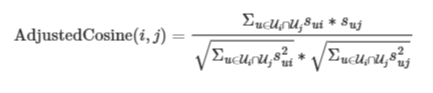  
Example: similarity between item 1 and item 3  
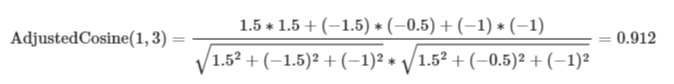

In [ ]:
iknn_adj = ItemKNN(k=2, similarity="cosine", mean_centered=True, verbose=VERBOSE).fit(dataset)
print(f"AdjustedCosine(1,3) = {iknn_adj.sim_mat[0, 2]:.3f}")

AdjustedCosine(1,3) = 0.912


The rating User 3 give to item 1 and item 6  
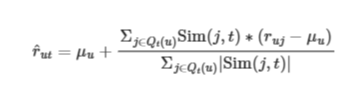  
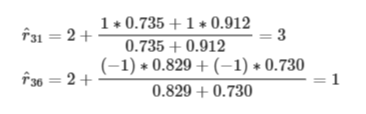

In [ ]:
print(f"R(3,1) = {iknn_adj.score(user_idx=2, item_idx=0):.1f}")
print(f"R(3,6) = {iknn_adj.score(user_idx=2, item_idx=5):.1f}")

R(3,1) = 3.0
R(3,6) = 1.0


Try it on MovieLens

In [ ]:
#ItemKNN methods
K = 50 #number of nearest neighbors
iknn_cosine = ItemKNN(k=K, similarity="cosine", name="ItemKNN-Cosine", verbose=VERBOSE)
iknn_pearson = ItemKNN(k=K, similarity="pearson", name="ItemKNN-Pearson", verbose=VERBOSE)
iknn_pearson_mc = ItemKNN(k=K, similarity="pearson",mean_centered=True, name="ItemKNN-Pearson-MC", verbose=VERBOSE)
iknn_adjusted = ItemKNN(k=K, similarity="cosine", mean_centered=True, name="ItemKNN-AdjustedCosine", verbose=VERBOSE)

feedback = movielens.load_feedback(variant="100K")
ratio_split = RatioSplit(feedback, test_size = 0.1, seed=SEED, verbose=VERBOSE)
cornac.Experiment(
    eval_method=ratio_split,
    models=[iknn_cosine, iknn_pearson, iknn_pearson_mc, iknn_adjusted],
    metrics=[cornac.metrics.RMSE()],
).run()


TEST:
...
                       |   RMSE | Train (s) | Test (s)
---------------------- + ------ + --------- + --------
ItemKNN-Cosine         | 0.9687 |    0.4476 |   1.9403
ItemKNN-Pearson        | 0.9624 |    0.2235 |   2.0788
ItemKNN-Pearson-MC     | 0.9573 |    0.2335 |   1.9091
ItemKNN-AdjustedCosine | 0.9099 |    0.2164 |   2.6773



###Similarity Reweighting

One common practice to increase the relative importance of the similarity scores is exponential amplification. 

To solve long-tailed distribution problem, we can use some techniques for feature reweighting from IR, especialy the Inverse Document Frequency (idf), score of each item i can be reweighted as:  
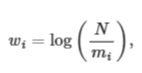  
N: number of users  
mi: number of ratings of item i  
Okapi BM25 is an improved version if TF-IDF.

In [ ]:
#UserKNN methods
K = 50
uknn_base = UserKNN(k=K, similarity="pearson", name="UserKNN-Base", verbose=VERBOSE)
uknn_amp1 = UserKNN(k=K, similarity="pearson", amplify=0.5, name="UserKNN-Amp0.5", verbose=VERBOSE)
uknn_amp2 = UserKNN(k=K, similarity="pearson", amplify=3.0, name="UserKNN-Amp3.0", verbose=VERBOSE)
uknn_idf = UserKNN(k=K, similarity="pearson", weighting="idf", name="UserKNN-IDF", verbose=VERBOSE)
uknn_bm25 = UserKNN(k=K, similarity="pearson", weighting="bm25", name="UserKNN-BM25", verbose=VERBOSE)

feedback = movielens.load_feedback(variant="100K")
ratio_split = RatioSplit(feedback, test_size=0.1, seed=SEED, verbose=VERBOSE)
cornac.Experiment(
    eval_method=ratio_split,
    models=[uknn_base, uknn_amp1, uknn_amp2, uknn_idf, uknn_bm25],
    metrics=[cornac.metrics.RMSE()]
).run()


TEST:
...
               |   RMSE | Train (s) | Test (s)
-------------- + ------ + --------- + --------
UserKNN-Base   | 0.8947 |    0.5352 |   4.7532
UserKNN-Amp0.5 | 0.8934 |    1.4397 |   3.8707
UserKNN-Amp3.0 | 0.9134 |    1.7377 |   5.4822
UserKNN-IDF    | 0.8955 |    0.2290 |   2.4467
UserKNN-BM25   | 0.8956 |    0.1239 |   1.6257



##Interpreting Recommendations

We can refer to metadata to uncover more information on the recommendations. Example: the title and genres

In [ ]:
user_df = pd.read_csv(
    cache("http://files.grouplens.org/datasets/movielens/ml-100k/u.user"),
    sep="|", names=["UserID", "Age", "Gender", "Occupation", "Zip Code"]
).set_index("UserID")

item_df = pd.read_csv(
    cache("http://files.grouplens.org/datasets/movielens/ml-100k/u.item"),
    sep="|", encoding="ISO-8859-1",
    names=["ItemID", "Title", "Release Date", "Video Release Date", "IMDb URL", 
         "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", 
         "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", 
         "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]
).set_index("ItemID").drop(columns=["Video Release Date", "IMDb URL", "unknown"])

###UserKNN (Pearson)

Select a user to explore her profile as well as her highly rated items in the training data.

In [ ]:
rating_mat = uknn_pearson.train_set.matrix
user_id2idx = uknn_pearson.train_set.uid_map
user_idx2id = list(uknn_pearson.train_set.user_ids)
item_id2idx = uknn_pearson.train_set.iid_map
item_idx2id = list(uknn_pearson.train_set.item_ids)

TOPK = 5
UID = 1
UIDX = uknn_pearson.train_set.uid_map[str(UID)]

print(f"UserID = {UID}")
print("-" * 25)
print(user_df.loc[UID])

rating_arr = rating_mat[UIDX].A.ravel()
top_rated_items = np.argsort(rating_arr)[-TOPK:]
print(f"\nTOP {TOPK} RATED ITEMS BY USER {UID}:")
item_df.loc[[int(item_idx2id[i]) for i in top_rated_items]]

UserID = 1
-------------------------
Age                   24
Gender                 M
Occupation    technician
Zip Code           85711
Name: 1, dtype: object

TOP 5 RATED ITEMS BY USER 1:


,Title,Release Date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
ItemID,,,,,,,,,,,,,,,,,,,,
96,Terminator 2: Judgment Day (1991),01-Jan-1991,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
48,Hoop Dreams (1994),01-Jan-1994,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
127,"Godfather, The (1972)",01-Jan-1972,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
150,Swingers (1996),18-Oct-1996,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
16,French Twist (Gazon maudit) (1995),01-Jan-1995,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


For instance, among the top 5 rated movies observed for User 1, 2 of them are Drama movies. Recommendations for this user can be obtained as:

In [ ]:
recommendations, scores = uknn_pearson.rank(UIDX)
print(f"\nTOP {TOPK} RECOMMENDATIONS FOR USER {UID}:")
print("Scores:", scores[recommendations[:TOPK]])
item_df.loc[[int(item_idx2id[i]) for i in recommendations[:TOPK]]]


TOP 5 RECOMMENDATIONS FOR USER 1:
Scores: [6.11605904 5.48557688 5.32202542 5.30147822 5.09619216]


,Title,Release Date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
ItemID,,,,,,,,,,,,,,,,,,,,
1309,"Very Natural Thing, A (1974)",01-Jan-1974,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
814,"Great Day in Harlem, A (1994)",01-Jan-1994,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1536,Aiqing wansui (1994),22-Jul-1996,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1500,Santa with Muscles (1996),08-Nov-1996,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1467,"Saint of Fort Washington, The (1993)",01-Jan-1993,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


We can see how the nearest neighbors of the user contribute towards the prediction of each movie.

In [ ]:
df = defaultdict(list)
sim_arr = uknn_pearson.sim_mat[UIDX].A.ravel()
for rec in recommendations[:TOPK]:
  rated_users = np.array([u for u in range(len(sim_arr)) if rating_mat[u, rec] != 0])
  nearest_neighbor = rated_users[np.argsort(sim_arr[rated_users])[-1:]].item()
  sim = sim_arr[nearest_neighbor]
  score = uknn_pearson.iu_mat[rec, nearest_neighbor]
  df["Recommendation"].append(item_df.loc[[int(item_idx2id[rec])]]["Title"].values[0])
  df["User NN"].append(nearest_neighbor)
  df["Similarity"].append(sim)
  df["Score by the NN"].append(score)
  df["Contribute"].append((score*sim) /np.abs(sim))
pd.DataFrame.from_dict(df)

,Recommendation,User NN,Similarity,Score by the NN,Contribute
0,"Very Natural Thing, A (1974)",703,-0.073508,-2.526316,2.526316
1,"Great Day in Harlem, A (1994)",20,0.471303,1.895833,1.895833
2,Aiqing wansui (1994),190,0.010587,1.732283,1.732283
3,Santa with Muscles (1996),184,0.289477,1.711735,1.711735
4,"Saint of Fort Washington, The (1993)",7,0.467937,1.640909,1.640909


###ItemKNN (AjustedCosine)

For ItemKNN, we take AdjustedCosine variant as our RS.

In [ ]:
rating_mat = iknn_adjusted.train_set.matrix
user_id2idx = iknn_adjusted.train_set.uid_map
user_idx2id = list(iknn_adjusted.train_set.user_ids)
item_id2idx = iknn_adjusted.train_set.iid_map
item_idx2id = list(iknn_adjusted.train_set.item_ids)

TOPK = 5
UID = 1
UIDX = user_id2idx[str(UID)]

print(f"UserID = {UID}")
print("-" *25)
print(user_df.loc[UID])

rating_arr = rating_mat[UIDX].A.ravel()
top_rated_items = np.argsort(rating_arr)[-TOPK:]
print(f"\nTOP {TOPK} RATED ITEMS BY USER {UID}:")
print("Ratings: ", rating_arr[top_rated_items])
item_df.loc[[int(item_idx2id[i]) for i in top_rated_items]]

UserID = 1
-------------------------
Age                   24
Gender                 M
Occupation    technician
Zip Code           85711
Name: 1, dtype: object

TOP 5 RATED ITEMS BY USER 1:
Ratings:  [5. 5. 5. 5. 5.]


,Title,Release Date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
ItemID,,,,,,,,,,,,,,,,,,,,
96,Terminator 2: Judgment Day (1991),01-Jan-1991,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
48,Hoop Dreams (1994),01-Jan-1994,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
127,"Godfather, The (1972)",01-Jan-1972,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
150,Swingers (1996),18-Oct-1996,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
16,French Twist (Gazon maudit) (1995),01-Jan-1995,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


The recommendations given to the User 1

In [ ]:
recommendations, scores = iknn_adjusted.rank(UIDX)
print(f"\nTOP {TOPK} RECOMMENDATIONS FOR USER {UID}:")
print("Scores:", scores[recommendations[:TOPK]])
item_df.loc[[int(item_idx2id[i]) for i in recommendations[:TOPK]]]


TOP 5 RECOMMENDATIONS FOR USER 1:
Scores: [4.65533227 4.64790324 4.64234397 4.61749142 4.61334104]


,Title,Release Date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
ItemID,,,,,,,,,,,,,,,,,,,,
115,"Haunted World of Edward D. Wood Jr., The (1995)",26-Apr-1996,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
113,"Horseman on the Roof, The (Hussard sur le toit...",19-Apr-1996,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
181,Return of the Jedi (1983),14-Mar-1997,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
165,Jean de Florette (1986),01-Jan-1986,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
198,Nikita (La Femme Nikita) (1990),01-Jan-1990,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


Let see how the nearest-neighbor of each recommended item contributes towards the final scores.

In [ ]:
df = defaultdict(list)
score_arr = iknn_adjusted.ui_mat[UIDX].A.ravel()
rated_items = np.nonzero(rating_mat[UIDX])[1]
for rec in recommendations[:TOPK]:
  sim_arr = iknn_adjusted.sim_mat[rec].A.ravel()
  nearest_neighbor = rated_items[np.argsort(sim_arr[rated_items])[-1]]
  sim = sim_arr[nearest_neighbor]
  score = score_arr[nearest_neighbor]
  df["Recommendation"].append(item_df.loc[[int(item_idx2id[rec])]]["Title"].values[0])
  df["Item NN"].append(nearest_neighbor)
  df["Similarity"].append(sim)
  df["Contribution"].append((score*sim)/np.abs(sim))
rec_df = pd.DataFrame.from_dict(df)
rec_df

,Recommendation,Item NN,Similarity,Contribution
0,"Haunted World of Edward D. Wood Jr., The (1995)",1565,1.0,0.410256
1,"Horseman on the Roof, The (Hussard sur le toit...",63,1.0,1.410256
2,Return of the Jedi (1983),305,1.0,1.410256
3,Jean de Florette (1986),1278,1.0,0.410256
4,Nikita (La Femme Nikita) (1990),364,1.0,1.410256


Another way to interpret the recommendation is to see how many neighbor items to the recommended item have been previously consumed by the user.

[Text(0, 0, 'Haunted World of Edward\nD. Wood Jr., The (1995)'),
 Text(1, 0, 'Horseman on the Roof, The\n(Hussard sur le toit, Le)\n(1995)'),
 Text(2, 0, 'Return of the Jedi (1983)'),
 Text(3, 0, 'Jean de Florette (1986)'),
 Text(4, 0, 'Nikita (La Femme Nikita)\n(1990)')]

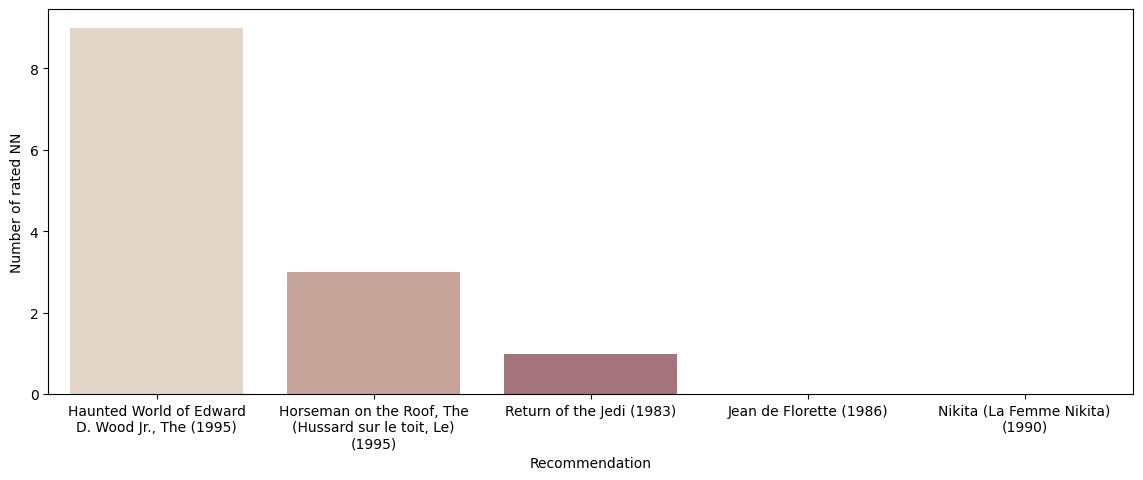

In [ ]:
rated_items = np.nonzero(rating_mat[UIDX])[1]
n_nearest_neighbors = []
for rec in recommendations[:TOPK]:
  nearest_neighbors = np.argsort(iknn_adjusted.sim_mat[rec].A.ravel())[-K:]
  n_nearest_neighbors.append(len(np.intersect1d(nearest_neighbors, rated_items)))
rec_df["Number of rated NN"] = n_nearest_neighbors

fig, ax = plt.subplots(figsize=(14,5))
sns.barplot(x="Recommendation", y = "Number of rated NN", data=rec_df, palette="ch:.25", ax=ax)
ax.set_xticklabels(textwrap.fill(x.get_text(), 25) for x in ax.get_xticklabels())

The top recommendation has 9 movies out of its 50 nearest-neighbors have been rated by the user.